### Clasificador Naive Bayes
Por Francisco Rivas
rivasj_25@hotmail.com 

El método de Naive Bayes es un algoritmo de clasificación que determina la probabilidad de que una observación $X = [x_1, ... , x_n]^T$ pertenezca a la clase $Y$, es decir $P(Y|X)$, aplicando el teorema de Bayes:

$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$


donde:

$Y \in \{1, ..., k\}$ ($k$ clases)

$P(X)=P(X|Y=1)P(Y=1)\ + ... +\ P(X|Y=k)P(Y=k)$ (regla de la probabilidad total)

Dada una nueva observación $X$, se calcula $P(Y=j|X)$ para $j=1,2,...,k$, y se asigna la nueva observación a la clase $Y$ que posee la mayor probabilidad.

Como el objetivo es comparar las probabilidades $P(Y=j|X)$, no es necesario calcular $P(X)$ porque es igual para todas las probabilidades $P(Y=j|X)$.


$$P(Y|X) = P(X|Y)P(Y)$$

Para determinar $P(X|Y)$, el método de Naive Bayes asume que la probabilidad condicional de los $x_i$ dado $Y$, es decir $P(x_i|Y)$, son condicionalmente independientes.

Bajo este supuesto se puede determinar $P(X|Y)$ como:

$$\prod_{i=1}^{n} P(x_i|Y)$$

Este método es relativamente sencillo y permite escoger una distribución para $P(x_i|Y)$ de acuerdo al origen de los datos.

Por ejemplo, si los parámetros $x_i$ toman valores discretos, se podría usar una distribución multinomial o Bernoulli si son valores binarios. Si los parámetros toman valores contínuos se podría modelar $P(X|Y)$ con una distribución Gaussiana Multivariada.

En el siguiente ejemplo se utilizará una distribución Gaussiana Multivariada en un algoritmo para clasificar las imágenes de dígitos del 0 al 9 escritos a mano. En este caso nuestro vector $X$ serán los valores de los colores, en 8 bits, de las imágenes.

A pesar de que los parámetros $x_i$ toman valores discretos, asumir una distribución Gaussiana Multivariada simplifica el problema y entrega una buena aproximación.

En un ejemplo futuro se resolverá el mismo problema aplicando una distribución multinomial y se compararán los resultados

### Dataset

Se utilizará la data MNIST que se puede descargar de

https://www.kaggle.com/c/digit-recognizer

El archivo zip tiene dos archivos csv: train.csv y test.csv

En este caso sólo se utilizará el archivo train.csv y se tomará el 80% de la data para entrenar el algoritmo y el 20% restante para validar.

### Ahora sí, manos a la data ... 

Nota: Este ejemplo fue tomado de 

https://towardsdatascience.com/naive-bayes-explained-108c095241eb?source=bookmarks---------0------------------


Primero importamos las librerías que vamos a utilizar

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 #openCV para hacer un preprocesamiento de las imágenes

Cargamos la data usando pd.read_csv() e imprimimos las primeras filas con .head()

In [4]:
#Esta parte depende de donde tenga el archivo train.csv
#En mi caso se encuentra en mi directorio actual

df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Como se puede observar, la columna label contiene el dígito representado por los 28x28=784 pixeles cuyos valores se encuentran en las columnas pixel0,..., pixel783.

El siguiente paso es dividir la data en dos partes, un 80% para entrenar y el 20% restante para validar. Este paso es pura decisión personal porque también podría usar toda la data en el archivo train.csv para entrenar y validar con la data en test.csv

Nota: las filas se encuentran de forma aleatoria por lo que no es necesario reordenar. 

In [5]:
n_filas = df.shape[0]
train = int(n_filas*0.8)

pixels_raw_train = np.array(df.loc[:train-1].drop(columns='label').values, dtype='uint8')
labels_train = np.array(df.loc[:train-1]['label'])

pixels_raw_test = np.array(df.loc[train:].drop(columns='label').values, dtype='uint8')
labels_test = np.array(df.loc[train:]['label'])

Es importante asignar el tipo 'uint8' a los arreglos que contienen los pixeles por el motivo que se realizará un preprocesamiento con openCV, y este método recibe objetos de ese tipo.

In [6]:
print(pixels_raw_train.shape)
print(pixels_raw_test.shape)

(33600, 784)
(8400, 784)


pixels_raw_train contiene 33600 observaciones $X \in {\rm I\!R}^{784}$

pixels_raw_test contiene 8400 observaciones $X \in {\rm I\!R}^{784}$

Ahora se hará una transformación a las imágenes con openCV, mediante un método llamado Histogram of Oriented Gradients (HOG). Esto mejora la precisión del algoritmo.

Al realizar la transformacion, $X \in {\rm I\!R}^{108}$, es decir, se reduce la cantidad de features $x_i$

Aquí la documentación https://docs.opencv.org/3.4/d5/d33/structcv_1_1HOGDescriptor.html

In [7]:
pixels_train = np.zeros((pixels_raw_train.shape[0], 108))
pixels_test = np.zeros((pixels_raw_test.shape[0], 108))

hog = cv2.HOGDescriptor((28,28), (14,14), (7,7), (14,14), 12)

for n in range(pixels_raw_train.shape[0]):
    pixels_train[n] = hog.compute(pixels_raw_train[n].reshape((28,28))).reshape(1,-1)
    
for n in range(pixels_raw_test.shape[0]):
    pixels_test[n] = hog.compute(pixels_raw_test[n].reshape(28,28)).reshape(1,-1)
    

El siguiente paso es determinar la distribución de $Y$, $P(Y)$

Para ello debemos contar los valores únicos en labels_train (en este caso son los dígitos del 0 al 9), y calculamos la distribución mediante la ecuación:

$$P(Y=k) = \frac{\sum_{j=1}^{m} 1\{Y_j = k\}}{m}$$

La ecuación anterior es simplemente la fracción de cada clase en la data de entrenamiento.

Nos ayudaremos de la función np.unique que devuelve los valores únicos y la cuenta de cada valor cuando el argumento return_counts es True

In [8]:
unicos, cuenta = np.unique(labels_train, return_counts=True)
py = cuenta/len(labels_train)

In [9]:
py

array([0.09761905, 0.11113095, 0.10047619, 0.10324405, 0.09705357,
       0.09071429, 0.09839286, 0.10467262, 0.09705357, 0.09964286])

Vamos a determinar $P(X|Y)$ usando una distribución Gaussiana Multivariada:

$$P(X|Y=k) = \frac{1}{{(2\pi)^{n/2}}{\mid {\Sigma} \mid}^{1/2}} exp(\frac{1}{2} (X-\mu)^T {\Sigma }^{-1}(X-\mu))$$

Donde
- $\mu$ es un vector $n-dimensional$, y corresponde a la media de la clase $k$
- $\Sigma$ es la matriz de covarianza $nxn$, correspondiente a la clase $k$

Reemplazando la ecuacion anterior en la ecuacion en el teorema de bayes (sin el termino $P(X)$) tenemos:

$$P(Y|X) = P(Y)[\frac{1}{{(2\pi)^{n/2}}{\mid {\Sigma} \mid}^{1/2}} exp(\frac{1}{2} (X-\mu)^T { \Sigma }^{-1}(X-\mu))]$$

La clase que tiene la probabilidad maxima calculada como $P(Y|X)$ es la misma si fuera calculada como $ln (P(Y|X))$. Nos valdremos de esto para simplificar el problema.

$$ln P(Y|X) = ln P(Y) - \frac{n}{2}ln(2\pi) - \frac{1}{2} ln \mid \Sigma \mid - \frac{1}{2} (X-\mu)^T {\Sigma }^{-1}(X-\mu) $$

El termino $\frac{n}{2}ln(2\pi)$ es un valor constante para cada clase, por lo que lo podemos quitar.
$$ln P(Y|X) = ln P(Y) - \frac{1}{2} ln \mid \Sigma \mid - \frac{1}{2} (X-\mu)^T {\Sigma }^{-1}(X-\mu) $$

### Una simplificacion mas...

En este punto ya tenemos lo suficiente para entrenar el algoritmo, es decir, determinar los parametros $\mu$ y $\Sigma$ para cada clase y empezar a hacer predicciones.

Para simplificar la matriz de covarianzas, vamos a asumir que los $x_i \in X$ son independientes entre si. Ojo, el metodo de Naive Bayes no asume esto, pero en este problema especifico, nos proporciona una buena aproximacion.

Dado que la $covarianza$ de variables independientes es cero, la matriz de varianzas y covarianzas se transforma en:

$$\Sigma = \begin{bmatrix}
\sigma_1^2 & 0 & ... \\
0 & \sigma_2^2 & ... \\
0 & .... & \sigma_n^2
\end{bmatrix}$$

El determinante e inversa de $\Sigma$ son

$$ \mid \Sigma \mid = \prod_{i = 1}^{n} \sigma_{i}^{2}$$

$$ 
\Sigma^{-1} = 
\begin{bmatrix}
\frac{1}{\sigma_1^2} & 0 & ... \\
0 & \frac{1}{\sigma_2^2} & ... \\
0 & .... & \frac{1}{\sigma_n^2}
\end{bmatrix}
$$

Finalmente tenemos:
$$ln\ P(Y|X) = ln\ P(Y) - \sum_{i = 1}^{n} ln\ \sigma_{i} - \frac{1}{2} \sum_{i=1}^{n}\ \left(\frac{x_i-\mu_i}{\sigma_i}\right)^2 $$

### Determinar los parametros $\mu$ y $\sigma$

In [10]:
def parameters(pixels_train, labels_train):
    # pixels_train es un vector mxn, es decir m observaciones (training points) de longitud n
    #labels_train es un vector n-dimensional que contiene la clase que representa cada observacion
    
    # means es un vector kxn, es decir, los k vectores de media de longitud n
    # stdvs es un vector kxn, es decir, los k vectores de desviaciones estandar de longitud n
    classes = np.unique(labels_train) # k clases [0,1,...9]
    means = np.zeros((len(classes), pixels_train.shape[1]), dtype=np.float64)
    stdvs = np.zeros((len(classes), pixels_train.shape[1]), dtype=np.float64)
    
    for i, clas in enumerate(classes):
        indexes = np.where(labels_train == clas)
        means[i] = np.mean(pixels_train[indexes], axis=0)
        stdvs[i] = np.std(pixels_train[indexes], axis=0)
    return means, stdvs

In [11]:
# funcion que devuelve los terminos que contienen las sumatorias de la ecuacion ln P(Y|X) 
def log_gaussian(x, mean, std):
    return -(np.sum(np.log(std)) + 0.5 * np.sum(((x - mean) / (std)) ** 2))

In [12]:
# funcion que predice la clase a la que pertenece la observacion X, dada la distribucion P(Y)
# los vectores de media de cada clase
# y los vectores de desviacion estandar de cada clase
def predict(x, py, means, stdvs):
    n_classes = len(py)
    # np.argmax toma un vector y devuelve la posicion i del valor maximo en el vector
    # en este caso las clases coinciden con la posicion en el vector, es decir, la clase
    # 0 se encuentra en la posicion 0 del vector
    return np.argmax([np.log(py[k]) + log_gaussian(x, means[k], stdvs[k]) for k in range(n_classes)])

In [13]:
means, stdvs = parameters(pixels_train, labels_train)

### Realizamos predicciones con las observaciones en pixels_test

In [14]:
predictions = [predict(i, py, means, stdvs) for i in pixels_test]

### Calculamos la proporcion de aciertos comparando las clases estimadas con las clases reales en labels_test

In [15]:
sum(predictions==labels_test)/len(labels_test)

0.9044047619047619

# Precision del 90%

### Ahora a graficar algunas imagenes 

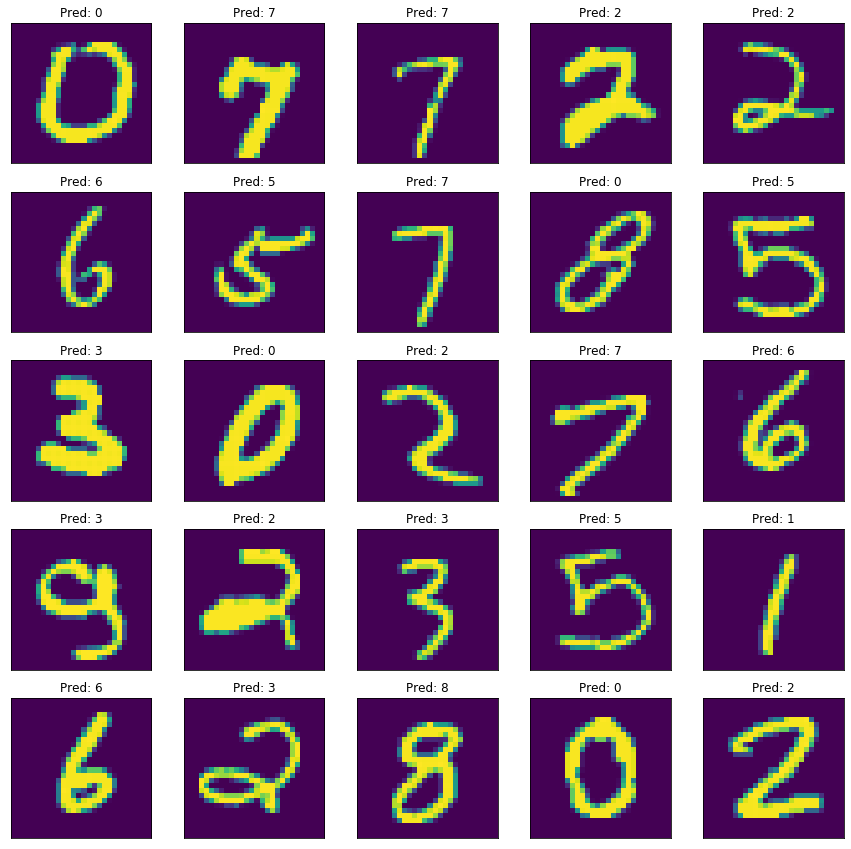

In [17]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
index = 0

#imshow takes a matrix
#each image have a shape of 28x28

for i in range(5):
    for j in range(5):
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].grid(False)
        ax[i][j].set_title('Pred: %s' % predictions[index])
        ax[i][j].imshow(pixels_raw_test[index].reshape(28,28))
        index += 1

plt.show()